In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cargar datos de entrenamiento y prueba

train_df = pd.read_excel('/content/drive/MyDrive/train_data.xlsx', names=['text', 'label'])
test_df = pd.read_excel('/content/drive/MyDrive/test_data.xlsx', names=['text', 'label'])


from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
training_labels = label_encoder.fit_transform(train_df['label'])
testing_labels = label_encoder.transform(test_df['label'])

print(train_df.head())
print(test_df.head())

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
nltk.download('punkt')

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)# Tokenizar el texto
    tokens = [token for token in tokens if token.lower() not in stopwords]
    tokens = [token.lower() for token in tokens]
    text = " ".join(tokens)
    return text

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

training_sequences = tokenizer.texts_to_sequences(train_df['text'])
testing_sequences = tokenizer.texts_to_sequences(test_df['text'])

max_length = 100
training_padded = keras.preprocessing.sequence.pad_sequences(training_sequences, maxlen=max_length, truncating='post')
testing_padded = keras.preprocessing.sequence.pad_sequences(testing_sequences, maxlen=max_length, truncating='post')

training_labels = np.array(train_df['label'])
testing_labels = np.array(test_df['label'])


In [8]:
embedding_dim = 16

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])


In [11]:
num_epochs = 10

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))


Epoch 1/10
687/687 [==============================] - 10s 14ms/step - loss: 0.8237 - accuracy: 0.6251 - val_loss: 0.6211 - val_accuracy: 0.7509
Epoch 2/10
687/687 [==============================] - 10s 15ms/step - loss: 0.6029 - accuracy: 0.7577 - val_loss: 0.4967 - val_accuracy: 0.8142
Epoch 3/10
687/687 [==============================] - 11s 15ms/step - loss: 0.4725 - accuracy: 0.8206 - val_loss: 0.4149 - val_accuracy: 0.8584
Epoch 4/10
687/687 [==============================] - 13s 18ms/step - loss: 0.3536 - accuracy: 0.8740 - val_loss: 0.3545 - val_accuracy: 0.8833
Epoch 5/10
687/687 [==============================] - 9s 13ms/step - loss: 0.2532 - accuracy: 0.9135 - val_loss: 0.3417 - val_accuracy: 0.8975
Epoch 6/10
687/687 [==============================] - 12s 17ms/step - loss: 0.1776 - accuracy: 0.9411 - val_loss: 0.3481 - val_accuracy: 0.9068
Epoch 7/10
687/687 [==============================] - 11s 15ms/step - loss: 0.1284 - accuracy: 0.9585 - val_loss: 0.3574 - val_accuracy: 

In [12]:
_, test_acc = model.evaluate(testing_padded, testing_labels)

print('Test accuracy:', test_acc)


172/172 [==============================] - 1s 4ms/step - loss: 0.4440 - accuracy: 0.9196
Test accuracy: 0.9195632338523865


In [13]:
new_texts = ['This day is great!', 'This night is terrible']
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = keras.preprocessing.sequence.pad_sequences(new_sequences, maxlen=max_length, truncating='post')

predictions = model.predict(new_padded)

for i, text in enumerate(new_texts):
    print(text, predictions[i])


1/1 [==============================] - 0s 113ms/step
This movie is great! [4.1358355e-05 6.8743467e-01 3.1252393e-01]
This movie is terrible. [9.9999189e-01 8.0825284e-06 6.8742123e-09]


172/172 [==============================] - 1s 6ms/step


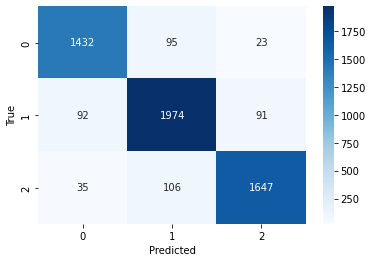

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = model.predict(testing_padded)

predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(testing_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(testing_padded)
predicted_labels = np.argmax(predictions, axis=1)
print(classification_report(testing_labels, predicted_labels))


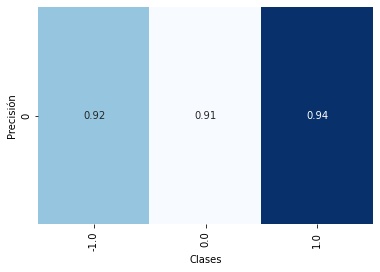

In [41]:
from sklearn.metrics import precision_score
import seaborn as sns
import matplotlib.pyplot as plt

class_names = np.unique(train_df['label'])

precision = precision_score(testing_labels, predicted_labels, average=None)


sns.heatmap([precision], cmap='Blues', annot=True, cbar=False, fmt='.2g')
plt.xlabel('Clases')
plt.ylabel('Precisión')
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=90)
plt.show()